## Simulator

In [1]:
import scipy.stats as stats
import scipy
import numpy as np
import matplotlib.pyplot as plt
import swyft
#import lightning as L 
import pytorch_lightning as pl

import torch
DEVICE = 'GPU'
freq = np.arange(5.00,1024,1/4)
pi = np.pi
sqrt = np.sqrt
H100 = 3.241e-18
h    = 0.679
H0   = h * H100

# Define Simulator
class Simulator(swyft.Simulator):
    def __init__(self, fref, psd, gamma, T_obs, Nbins=4076, bounds=None):
        super().__init__()
        self.fref      = fref
        self.psd       = psd
        self.gamma     = gamma
        self.T_obs     = T_obs
        
        self.transform_samples = swyft.to_numpy32
        self.Nbins = Nbins
        self.freq = np.linspace(5., 1024 + (1024-5)/Nbins , Nbins)
        self.sample_z = swyft.RectBoundSampler([stats.loguniform(1e-8,1e-7), #alpha
                                                stats.uniform(0,3)], #omega alpha
                                                bounds = bounds) #bounds changes range of the prior

    def psd_interp(self):
        return scipy.interpolate.interp1d(self.psd[:,0], self.psd[:,1])(self.freq)
    
    def gamma_interp(self):
        return scipy.interpolate.interp1d(self.gamma[:, 0], self.gamma[:, 1])(self.freq)
    
    def sigma(self):
        numerator = (20*pi**2*self.freq**3)**2 * self.psd_interp()**2
        denomenator = (3*H0**2)**2 * 8*self.gamma_interp()**2
        T = 1/(self.freq[1]-self.freq[0])
        N = 2*self.T_obs // T - 1
        return np.sqrt(numerator/denomenator/N)
    
    def C_groundtruth(self, z):
        Omega_ref = z[0]
        alpha     = z[1]
        C_hat_ij = Omega_ref * (self.freq/self.fref)**alpha
        return C_hat_ij
    
    def build(self, graph):
        z = graph.node('z', self.sample_z)
        m = graph.node('m', self.C_groundtruth, z)
        x = graph.node("x", lambda m: m + np.random.normal(0, self.sigma()), m) #Ground truth wih sigma noise
        sigma = graph.node('sigma',self.sigma)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [01:12<00:00, 1387.31it/s]


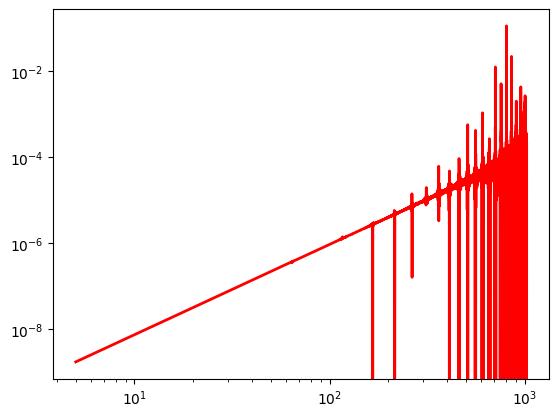

In [15]:
# Simluate data 

fref = 25
CE_PSD = np.genfromtxt("data/cosmic_explorer_40km_for_paper.txt")
CE_PSD[0, 0]  = 4.99999999999999999
CE_PSD[:, 1] = CE_PSD[:, 1]**2
gamma_HL = np.genfromtxt("data/gamma_HL.txt")
T_obs = 365 * 24 * 3600

sim = Simulator(fref, CE_PSD, gamma_HL, T_obs, bounds=None)
obs = sim.sample(conditions = {'z': np.array([5e-8, 2.1])})
samples = sim.sample(100000) # 100 samples

# Plot simulated data
#for i in range(len(samples)):
#    plt.loglog(sim.freq, samples[i]['x'], 'k')
plt.loglog(sim.freq, obs['x'], 'r', lw=2)

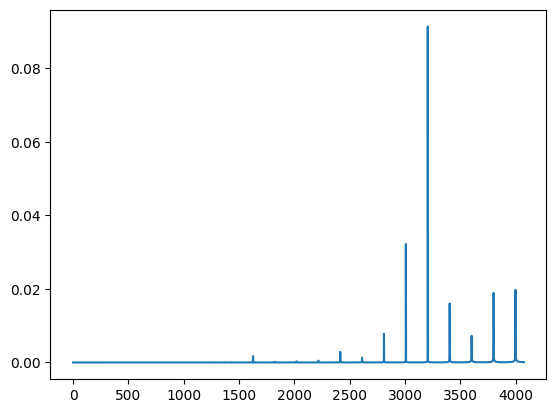

In [16]:
plt.plot(samples[5]['sigma'])

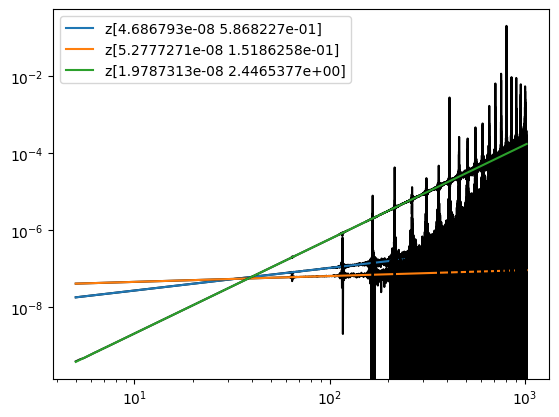

In [17]:
for i in [5, 2, 50]:
    plt.loglog(sim.freq, samples['x'][i], color='k')
    plt.loglog(sim.freq, samples['m'][i], label="z" + str(samples['z'][i]))
plt.legend()

In [18]:
samples['x']

array([[ 1.92415843e-08,  2.00209929e-08,  2.08253823e-08, ...,
        -3.44514738e-05,  1.10405446e-04,  1.97671339e-04],
       [ 3.15581019e-08,  3.17001891e-08,  3.17966524e-08, ...,
         4.24403843e-05, -6.50092843e-05, -7.09056076e-06],
       [ 4.13439594e-08,  4.16416093e-08,  4.19413517e-08, ...,
         1.05899519e-04,  6.53872194e-05, -1.69762454e-04],
       ...,
       [ 2.45367549e-08,  2.49462619e-08,  2.53073793e-08, ...,
         1.23541933e-04, -5.08984558e-05, -1.01817741e-05],
       [ 9.52790291e-09,  1.01520090e-08,  1.08014424e-08, ...,
         1.94938868e-04,  4.76928199e-06,  3.95297175e-05],
       [ 5.34108402e-09,  5.70768810e-09,  6.06007067e-09, ...,
         7.89939804e-05,  1.08546417e-04,  5.38927125e-05]], dtype=float32)

## Variational Autoencoder

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

# Define VAE

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder layers (same as before, but with mu and logvar layers)
        self.encoder_fc1 = nn.Linear(4076, 1024)
        self.encoder_fc2 = nn.Linear(1024, 256)
        self.encoder_fc3 = nn.Linear(256, 64)
        self.encoder_fc4 = nn.Linear(64, 16)

        # Latent space mean and log variance
        self.fc_mu = nn.Linear(16, 8)
        self.fc_logvar = nn.Linear(16, 8)

        # Decoder layers
        self.decoder_fc1 = nn.Linear(8, 16)
        self.decoder_fc2 = nn.Linear(16, 64)
        self.decoder_fc3 = nn.Linear(64, 256)
        self.decoder_fc4 = nn.Linear(256, 1024)
        self.decoder_fc5 = nn.Linear(1024, 4076)

        self.dropout = nn.Dropout(0.2)

    def encode(self, x):
        # Encode input to latent space
        x = F.relu(self.encoder_fc1(x))
        x = F.relu(self.encoder_fc2(x))
        x = F.relu(self.encoder_fc3(x))
        x = F.relu(self.encoder_fc4(x))

        # Get the mean and log variance for the latent space
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        return mu, logvar

    def reparameterize(self, mu, logvar):
        # Reparameterization trick: z = mu + sigma * epsilon
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std) # random noise
        z = mu + eps * std # latent variable
        return z

    def decode(self, z):
        # Decode the sampled latent vector
        z = F.relu(self.decoder_fc1(z))
        z = F.relu(self.decoder_fc2(z))
        z = F.relu(self.decoder_fc3(z))
        z = F.relu(self.decoder_fc4(z))
        z = self.decoder_fc5(z)
        return z

    def forward(self, x):
        # Forward pass: encode, reparameterize, decode
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        z = self.dropout(z)
        x_reconstructed = self.decode(z)
        return x_reconstructed, mu, logvar


# Instantiate and print summary
model = VAE()
summary(model, input_size=(1, 4076))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 1024]       4,174,848
            Linear-2               [-1, 1, 256]         262,400
            Linear-3                [-1, 1, 64]          16,448
            Linear-4                [-1, 1, 16]           1,040
            Linear-5                 [-1, 1, 8]             136
            Linear-6                 [-1, 1, 8]             136
           Dropout-7                 [-1, 1, 8]               0
            Linear-8                [-1, 1, 16]             144
            Linear-9                [-1, 1, 64]           1,088
           Linear-10               [-1, 1, 256]          16,640
           Linear-11              [-1, 1, 1024]         263,168
           Linear-12              [-1, 1, 4076]       4,177,900
Total params: 8,913,948
Trainable params: 8,913,948
Non-trainable params: 0
---------------------------

In [20]:
# Pre-Process Data

from torch.utils.data import TensorDataset
import pandas as pd
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

x_samples = samples['x'] 
m_samples = samples['m']

# Scaling data across each sample (need to transpose first)
transposed_x = x_samples.T
transposed_m = m_samples.T

scaler = StandardScaler()
#scaler = MinMaxScaler()

x_T_scaled = scaler.fit_transform(transposed_x)
m_T_scaled = scaler.fit_transform(transposed_m)

x_scaled = x_T_scaled.T
m_scaled = m_T_scaled.T

x_train, x_test, m_train, m_test = train_test_split(x_scaled, m_scaled, test_size=0.1)

from torch.utils.data import TensorDataset

# Convert to tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
m_train_tensor = torch.tensor(m_train, dtype=torch.float32)
m_test_tensor = torch.tensor(m_test, dtype=torch.float32)

# Define Data Loaders
train_dataset = TensorDataset(x_train_tensor, m_train_tensor)
test_dataset = TensorDataset(x_test_tensor, m_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [21]:
x_train_tensor.shape

torch.Size([90000, 4076])

In [22]:
# Check that normalization worked
print("Min: ",np.min(x_scaled[0,:]))
print("Max: ",np.max(x_scaled[0,:]))
print("Mean: ",np.average(x_scaled[0,:]))
print("Var: ", np.var(x_scaled[0,:]))

Min:  -11.574533
Max:  60.690685
Mean:  9.358924e-10
Var:  0.99999994


In [23]:
x_train.shape

(90000, 4076)

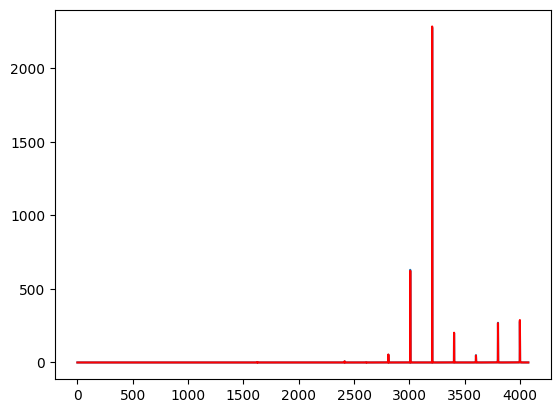

In [24]:
# Getting variance in each dimension of data
def Var_By_Column(data):
    
    sigma = np.zeros(len(data[0,:]))

    for i in range(len(sigma)):
        sigma[i] = np.var(data[:,i])

    return sigma

sig_test = Var_By_Column(x_test)
sig_train = Var_By_Column(x_train)

plt.plot(sig_test)
plt.plot(sig_train, c="r")

In [25]:
# VAE Weighted Loss
def VAE_WeightedLoss(sigma, predictions, targets, mu, logvar):
    """
    Computes the total loss for a Variational Autoencoder (VAE), including:
    - Weighted Mean Squared Error (MSE) loss between predictions and targets.
    - Kullback-Leibler Divergence (KL divergence) to regularize the latent space.
    
    Args:
        sigma (list or torch.Tensor): The variance weights for each dimension.
        predictions (torch.Tensor): The reconstructed values from the VAE.
        targets (torch.Tensor): The target (original input) values.
        mu (torch.Tensor): The mean of the latent space distribution.
        logvar (torch.Tensor): The log variance of the latent space distribution.
        
    Returns:
        torch.Tensor: The total loss, combining weighted MSE loss and KL divergence.
    """
    #ensure sigma is a tensor if it is not already
    if not isinstance(sigma, torch.Tensor):
        sigma = torch.Tensor(sigma)

    #ensure predictons and targets have same shape
    assert predictions.shape == targets.shape, "Shapes of predictions and targets must match"

    # Weighted Mean Squared Error loss
    squared_error = 1 / sigma**2 * (predictions - targets)**2
    weighted_mse_loss = torch.mean(squared_error)

    # KL Divergence loss
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Total loss: MSE + KL divergence
    total_loss = weighted_mse_loss + kl_divergence

    return total_loss


Epoch [1/50], Loss: 3479.8428671441
Epoch [2/50], Loss: 1895.7107106120
Epoch [3/50], Loss: 1624.2256841146
Epoch [4/50], Loss: 1454.3828003255
Epoch [5/50], Loss: 1340.1937578559
Epoch [6/50], Loss: 1266.4661514106
Epoch [7/50], Loss: 1187.1584909505
Epoch [8/50], Loss: 1137.8970050673
Epoch [9/50], Loss: 1080.2749440755
Epoch [10/50], Loss: 1037.7076386285
Epoch [11/50], Loss: 1000.1878774848
Epoch [12/50], Loss: 961.6197273003
Epoch [13/50], Loss: 924.2568506510
Epoch [14/50], Loss: 896.8601338650
Epoch [15/50], Loss: 856.3083220269
Epoch [16/50], Loss: 830.6205351671
Epoch [17/50], Loss: 798.3372619683
Epoch [18/50], Loss: 773.8725821181
Epoch [19/50], Loss: 748.4434557020
Epoch [20/50], Loss: 734.4643422906
Epoch [21/50], Loss: 711.6955048937
Epoch [22/50], Loss: 694.2253875434
Epoch [23/50], Loss: 668.9958713759
Epoch [24/50], Loss: 669.3223560927
Epoch [25/50], Loss: 633.8953182509
Epoch [26/50], Loss: 623.6261114475
Epoch [27/50], Loss: 622.6911130208
Epoch [28/50], Loss: 605.0

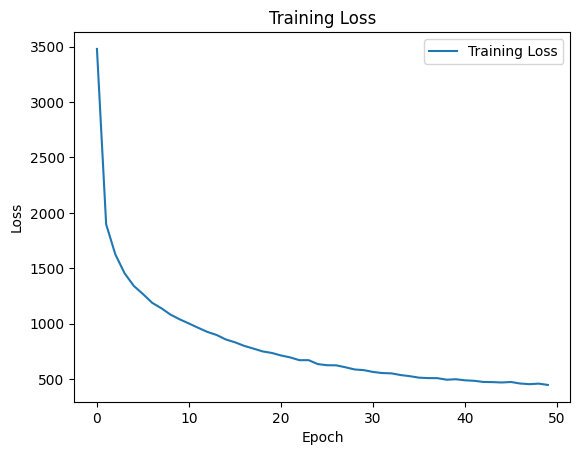

In [26]:
import torch.optim as optim
import matplotlib.pyplot as plt

# Variational Autoencoder
model = VAE()
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Smaller learning rate
sig_train = sig_train  # list of variances per feature

train_losses = []
# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()

        # Forward pass through the VAE
        outputs, mu, logvar = model(inputs.unsqueeze(1))  # Outputs, mu, logvar

        # Compute the loss
        loss = VAE_WeightedLoss(sig_train, outputs, targets.unsqueeze(1), mu, logvar)
        
        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the loss
        running_loss += loss.item() * inputs.size(0)

    # Compute the average loss for this epoch
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    
    # Print the loss for this epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.10f}")

# Plot the training loss
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()


In [30]:
#torch.save(model,'VAE_model_pytorch_V2.pt')
#model = torch.load('VAE_model_pytorch_V2.pt')

In [31]:

model.eval()  
test_loss = 0.0

with torch.no_grad():  #disable gradient calculation for evaluation
    for inputs, targets in test_loader:

        outputs, mu, logvar = model(inputs.unsqueeze(1))
        loss = VAE_WeightedLoss(sig_test, outputs, targets.unsqueeze(1), mu, logvar)
        test_loss += loss.item() * inputs.size(0)

# average test loss
test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")


Test Loss: 1362.2561


Test loss with basic model: 1601.3543
Test loss with more layers: 1365.7853

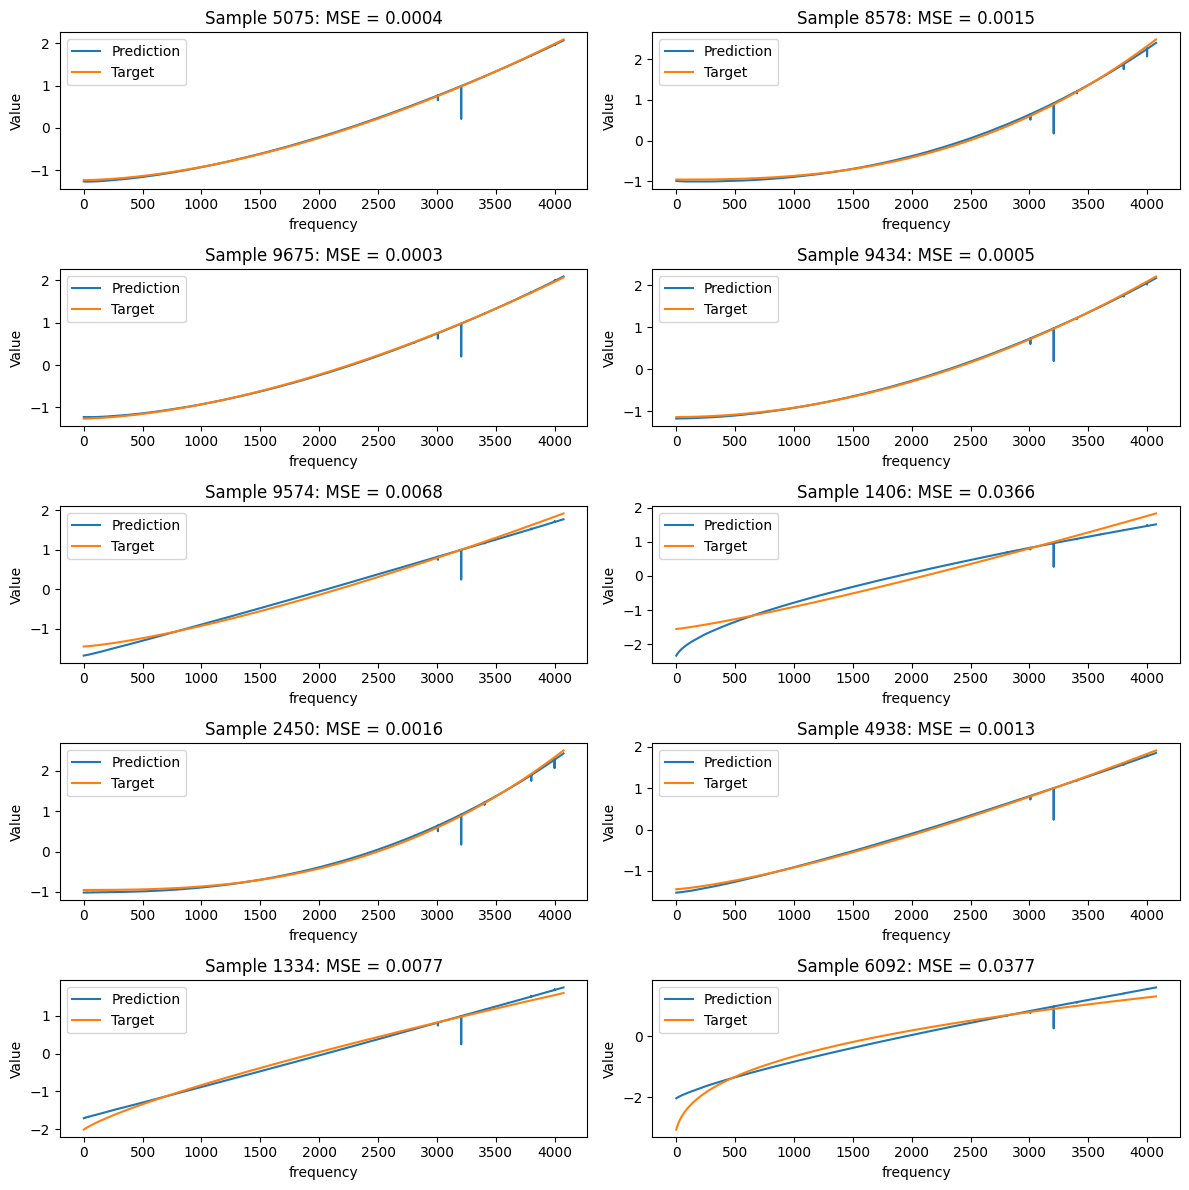

In [32]:
import random
import matplotlib.pyplot as plt

# Randomly select 6 indices
num_samples = 10
random_indices = random.sample(range(len(test_dataset)), num_samples)

num_rows = 5
num_cols = 2

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))

for i, idx in enumerate(random_indices):
    row = i // num_cols
    col = i % num_cols
    
    sample, target = test_dataset[idx]

    # Pass the sample through the model to get the prediction
    with torch.no_grad():
        model.eval()
        prediction, _, _ = model(sample.unsqueeze(0).unsqueeze(0))  # extract prediction from model output

    mse = F.mse_loss(prediction.squeeze(), target).item() # calculate error

    # Plot prediction and target
    axs[row, col].plot(prediction.squeeze().numpy(), label='Prediction')
    axs[row, col].plot(target.numpy(), label='Target')
    axs[row, col].set_xlabel('frequency')
    axs[row, col].set_ylabel('Value')
    axs[row, col].set_title(f'Sample {idx}: MSE = {mse:.4f}')
    axs[row, col].legend()

# Hide any empty subplots
for i in range(len(random_indices), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()


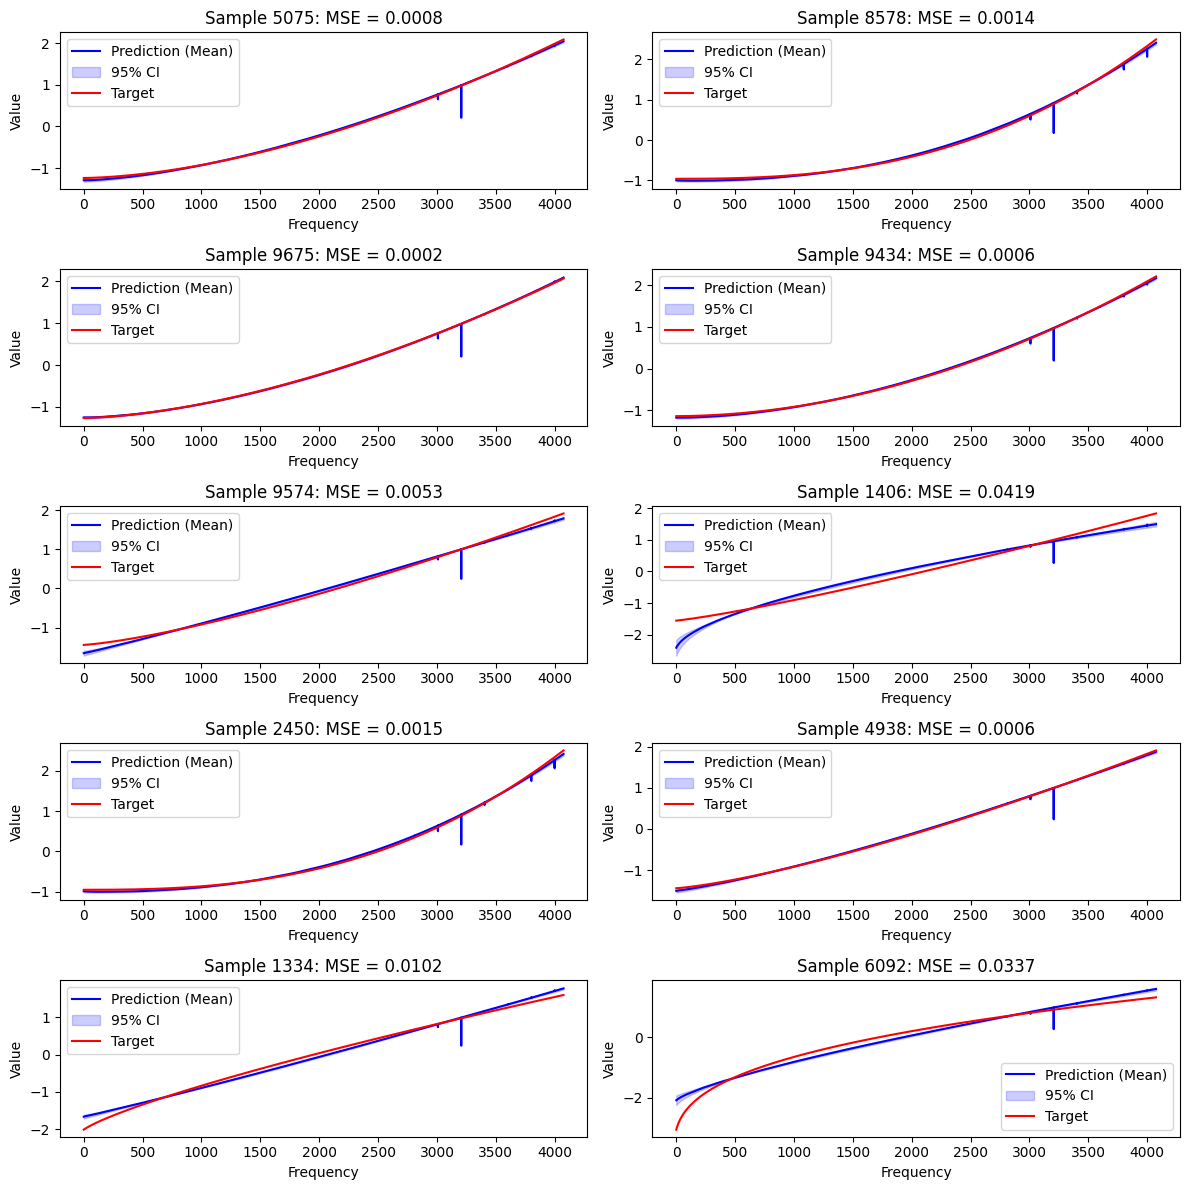

In [33]:
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))

for i, idx in enumerate(random_indices):
    row = i // num_cols
    col = i % num_cols
    
    sample, target = test_dataset[idx]
    samples = []

    for _ in range(10000):  # Simulate 10,000 model outputs
        with torch.no_grad():
            model.eval()
            prediction, _, _ = model(sample.unsqueeze(0).unsqueeze(0)) 
        samples.append(prediction.squeeze().numpy())  # Convert to numpy and store

    # Convert the list of samples to a numpy array for easier calculations
    samples = np.array(samples)

    samples_mean = np.mean(samples, axis=0)

    samples_std = np.std(samples, axis=0)
     # Compute the 95% confidence interval (mean ± 1.96 * standard deviation)
    ci_lower = samples_mean - 1.96 * samples_std
    ci_upper = samples_mean + 1.96 * samples_std


    mse = F.mse_loss(torch.tensor(samples_mean), target).item()

   
    # Plot prediction and target
    axs[row, col].plot(samples_mean, label='Prediction (Mean)', color='blue')
    axs[row, col].fill_between(range(len(samples_mean)), ci_lower, ci_upper, color='blue', alpha=0.2, label='95% CI')
    axs[row, col].plot(target.numpy(), label='Target', color='red')
    axs[row, col].set_xlabel('Frequency')
    axs[row, col].set_ylabel('Value')
    axs[row, col].set_title(f'Sample {idx}: MSE = {mse:.4f}')
    axs[row, col].legend()

# Hide any empty subplots
for i in range(len(random_indices), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()